In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
names = open('../makemore/names.txt').read().splitlines()
len(names)

32033

In [5]:
stoi = {}
itos = {}
for i,c in enumerate(['.'] + sorted(set(''.join(names)))): 
    stoi[c] = i
    itos[i] = c

In [6]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(len(names) * 0.8)
n2 = int(len(names) * 0.9)
block_size = 3

def build_dataset(words):
    x, y = [], []
    for word in words: 
        context = [0] * block_size
        for c in list(word) + ['.']:
            x.append(list(context))
            y.append(stoi[c])
            
            context = context[1:] + [stoi[c]]
    return torch.tensor(x),torch.tensor(y)

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xval, Yval = build_dataset(names[n2:])

print()
print(f"{Xtr.shape=}, {Ytr.shape}")
print(f"{Xdev.shape=}, {Ydev.shape}")
print(f"{Xval.shape=}, {Yval.shape}")


Xtr.shape=torch.Size([182625, 3]), torch.Size([182625])
Xdev.shape=torch.Size([22655, 3]), torch.Size([22655])
Xval.shape=torch.Size([22866, 3]), torch.Size([22866])


In [7]:
# create the network 
vocab_size = 27
emb_size = 10
hidden_n = 200

In [8]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, hidden_n), generator=g) * (5/3)/((block_size * emb_size) ** 0.5)
b1 = torch.randn((hidden_n), generator=g) * 0.01

bngain = torch.ones((1, hidden_n), )
bnbias = torch.zeros((1, hidden_n), )
bnmean_running = torch.zeros((1, hidden_n))
bnstd_running = torch.ones((1, hidden_n))

W2 = torch.randn((hidden_n, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size), generator=g) * 0

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

In [9]:
print(sum([p.nelement() for p in parameters]))

12297


In [209]:
for p in parameters: 
    p.requires_grad = True

epochs = 200000
stepi = []
lossi = []

In [210]:
max_steps = 200000
lossi = []
for i in range(max_steps): 
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], size=(32,),  generator=g)
    
    emb = C[Xtr[ix]] # n X 3 x 10
    hpreact = emb.view(-1, block_size * emb_size) @ W1 + b1 # N x 200 
    
    # batch normalization
    bnmeani = torch.mean(hpreact, dim=0, keepdim=True)
    bnstdi = torch.std(hpreact, dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # N x 200, 1 x 200
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h1 = torch.tanh(hpreact) # n x 100
    logits = h1 @ W2 + b2 # n x 27
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    

      0/ 200000: 3.7624
  10000/ 200000: 2.2386
  20000/ 200000: 1.9157
  30000/ 200000: 2.1913
  40000/ 200000: 1.7150
  50000/ 200000: 2.0573
  60000/ 200000: 2.2525
  70000/ 200000: 2.2429
  80000/ 200000: 2.2566
  90000/ 200000: 2.4529
 100000/ 200000: 1.9217
 110000/ 200000: 2.0208
 120000/ 200000: 2.1395
 130000/ 200000: 2.0867
 140000/ 200000: 2.5001
 150000/ 200000: 2.5454
 160000/ 200000: 2.0944
 170000/ 200000: 2.2329
 180000/ 200000: 2.3888
 190000/ 200000: 2.1201


In [215]:
@torch.no_grad
def split_loss(t): 
    x, y = {
        'train': (Xtr, Ytr), 
        'dev': (Xdev, Ydev),
        'val': (Xval, Yval)
    }[t]
    
    emb = C[x] # n X 3 x 10
    hpreact = emb.view(-1, block_size * emb_size) @ W1 + b1 # n x 100
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h1 = torch.tanh(hpreact)

    logits = h1 @ W2 + b2 # n x 27
    loss = F.cross_entropy(logits, y)
    print(t, loss.item())
    return loss

split_loss('train')
split_loss('val')
    

train 2.077134132385254
val 2.117314577102661


tensor(2.1173)

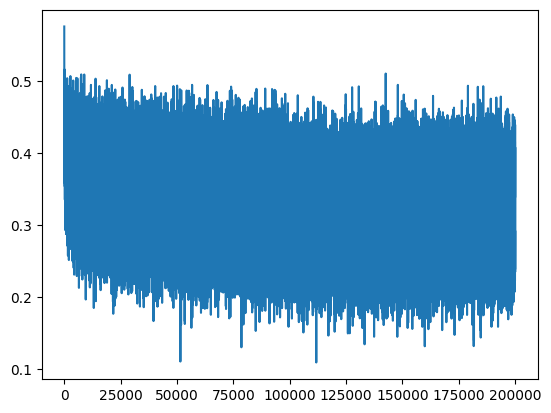

In [212]:
plt.plot(lossi)

In [213]:
# Sampling
for i in range(10): 
    context = [0] * block_size
    out = []
    while True:     
        emb = C[torch.tensor(context)] # n X 3 x 10
        h1 = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1) # n x 100
        logits = h1 @ W2 + b2 # n x 27
        
        log_counts = logits.exp()
        probs = log_counts / log_counts.sum(dim=1,keepdim=True)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        out.append(ix)
        if ix == 0: 
            break
    print(''.join(itos[i] for i in out))
        
        

madrristylerna.
mugchvton.
fadann.
mayzleigh.
zaqu.
spaull.
tyu.
btynn.
maskf.
kharlie.


In [180]:
torch.tensor([1/27]).log()

tensor([-3.2958])

## Original losses
train 2.24954891204834
val 2.2998268604278564

## After confident last layer init change
train 2.067924737930298
val 2.131237506866455

## init at other layers as well 
train 2.0907046794891357
val 2.1283624172210693

## kaiming 
train 2.038309097290039
val 2.1067142486572266

## batch norm
train 2.077134132385254
val 2.117314577102661

In [227]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [229]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2899


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.94%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.44%


Text(0.5, 1.0, 'activation distribution')

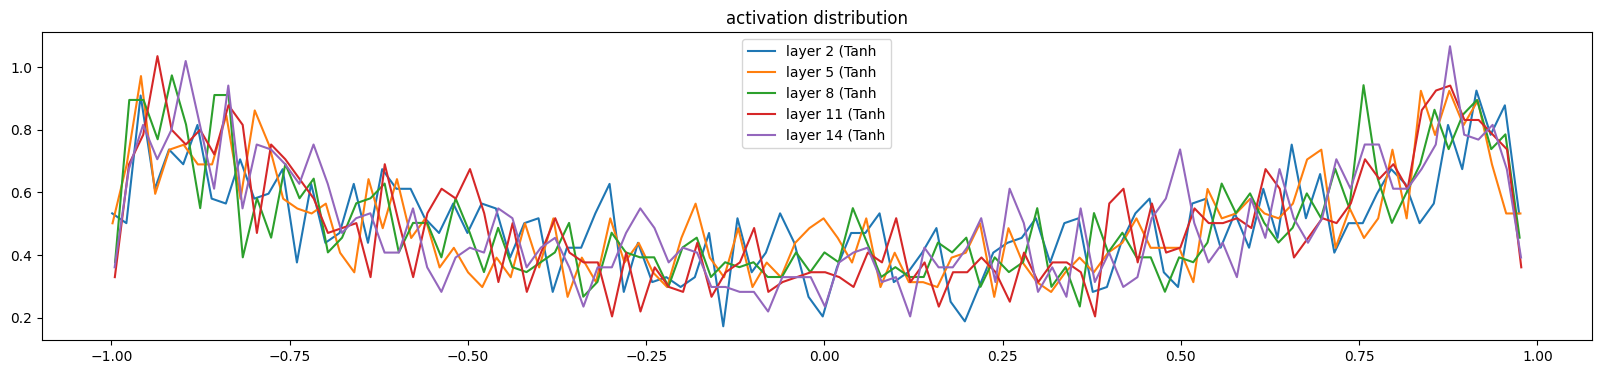

In [230]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.033688e-03
layer 5 (      Tanh): mean +0.000000, std 2.344540e-03
layer 8 (      Tanh): mean -0.000000, std 2.059891e-03
layer 11 (      Tanh): mean -0.000000, std 1.799660e-03
layer 14 (      Tanh): mean +0.000000, std 1.719999e-03


Text(0.5, 1.0, 'gradient distribution')

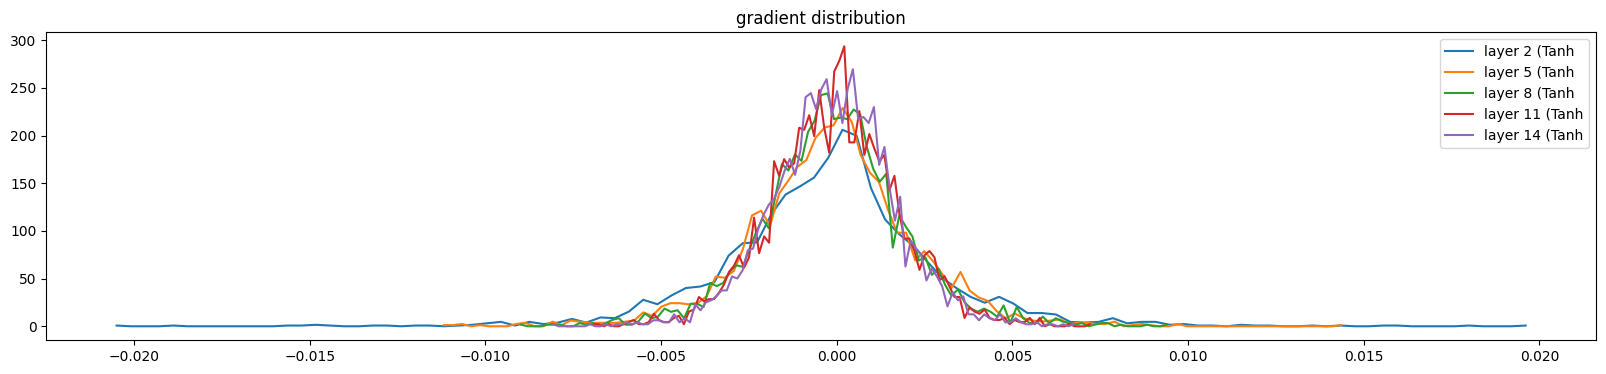

In [231]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.239334e-02 | grad:data ratio 1.238101e-02
weight  (30, 100) | mean -0.000208 | std 1.328038e-02 | grad:data ratio 7.009795e-02
weight (100, 100) | mean -0.000136 | std 8.809253e-03 | grad:data ratio 8.596870e-02
weight (100, 100) | mean +0.000013 | std 7.155363e-03 | grad:data ratio 6.967279e-02
weight (100, 100) | mean -0.000002 | std 6.609131e-03 | grad:data ratio 6.482919e-02
weight (100, 100) | mean -0.000086 | std 5.723899e-03 | grad:data ratio 5.624304e-02
weight  (100, 27) | mean +0.000075 | std 1.126456e-02 | grad:data ratio 1.083258e-01


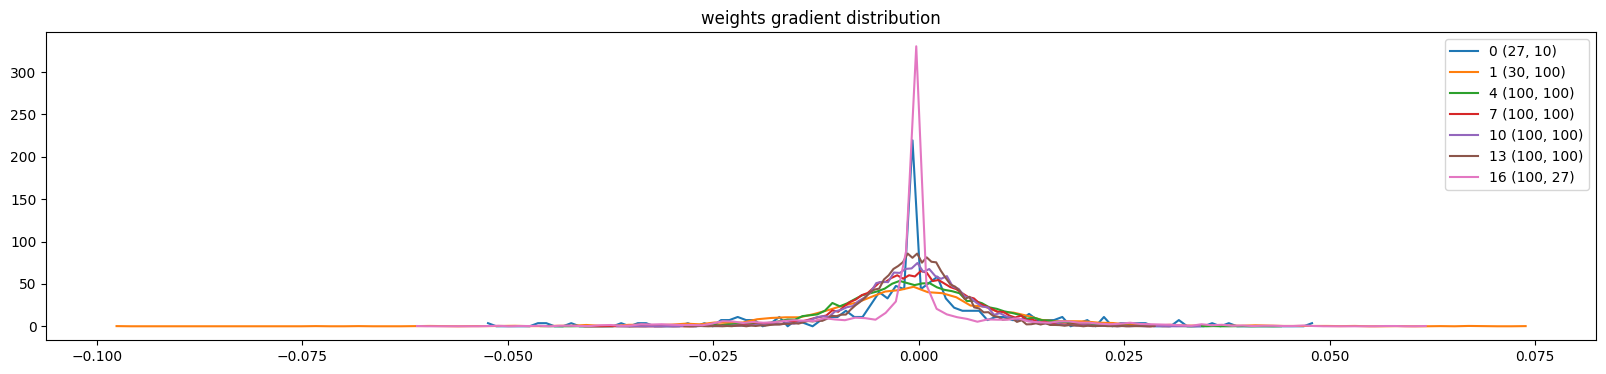

In [232]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');